# *Martijntrilogie*

## STELLING 1: Het rijm is stabieler dan de voorgaande delen in een vers

In [3]:
import pytensor
pytensor.config.cxx = ""
import pandas as pd
import bambi as bmb #bayesian model-building interface on top of pymc
import pymc as pm
import arviz as az #exploratory analysis of Bayesian models
import numpy as np 
import os

from sklearn.preprocessing import scale, StandardScaler #feature scaling (i.e., standardizing or normalizing data)

RANDOM_SEED = 8927 #fixed random seed number used to ensure reproducibility of results that depend on random number generation.
rng = np.random.default_rng(RANDOM_SEED)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk", palette='pastel')
plt.style.use("dark_background")
sns.set(style="ticks", context="talk", palette='Greys')
plt.style.use("default")

from matplotlib import font_manager
font_dirs = ["/data/Alegreya"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams["font.family"] = "Alegreya"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Data importeren - alignering met CollateX en Needleman-Wunch

In [17]:
df = pd.read_csv('../data/matches_martijntrilogie/matches_cx.csv', header=0)
df2 = pd.read_csv('../data/matches_martijntrilogie/matches_nw.csv', header=0)
df = df.rename(columns={'relative position': 'rel_vpos'})
df2 = df2.rename(columns={'relative position': 'rel_vpos'})

# Filter df
df = df[df['id_ms'] != 'M3_39_508']
df = df[df['id_ms'] != 'M1_75_976']
df = df[df['id_ms'] != 'M1_01_000']
df = df[df['id_ms'] != 'M2_01_000']
df = df[df['id_ms'] != 'M3_01_000']
df = df[df['id_ms'] != 'M2_26_339']
df = df[df['line1'] != 'dus']
df = df[df['line2'] != 'dus']
df = df[df['line1'] != 'dominus']
df = df[df['line2'] != 'dominus']

# Filter df2 (APART!)
df2 = df2[df2['id_ms'] != 'M3_39_508']
df2 = df2[df2['id_ms'] != 'M1_75_976']
df2 = df2[df2['id_ms'] != 'M1_01_000']
df2 = df2[df2['id_ms'] != 'M2_01_000']
df2 = df2[df2['id_ms'] != 'M3_01_000']
df2 = df2[df2['id_ms'] != 'M2_26_339']
df2 = df2[df2['line1'] != 'dus']
df2 = df2[df2['line2'] != 'dus']
df2 = df2[df2['line1'] != 'dominus']
df2 = df2[df2['line2'] != 'dominus']

# Check
print(f"df shape: {df.shape}")
print(f"df2 shape: {df2.shape}")
print(f"df mismatch mean: {df['mismatch'].mean():.4f}")
print(f"df2 mismatch mean: {df2['mismatch'].mean():.4f}")

df shape: (1628241, 14)
df2 shape: (1659257, 14)
df mismatch mean: 0.1566
df2 mismatch mean: 0.1581


## Spellingvariatie: vergelijking op tekenniveau

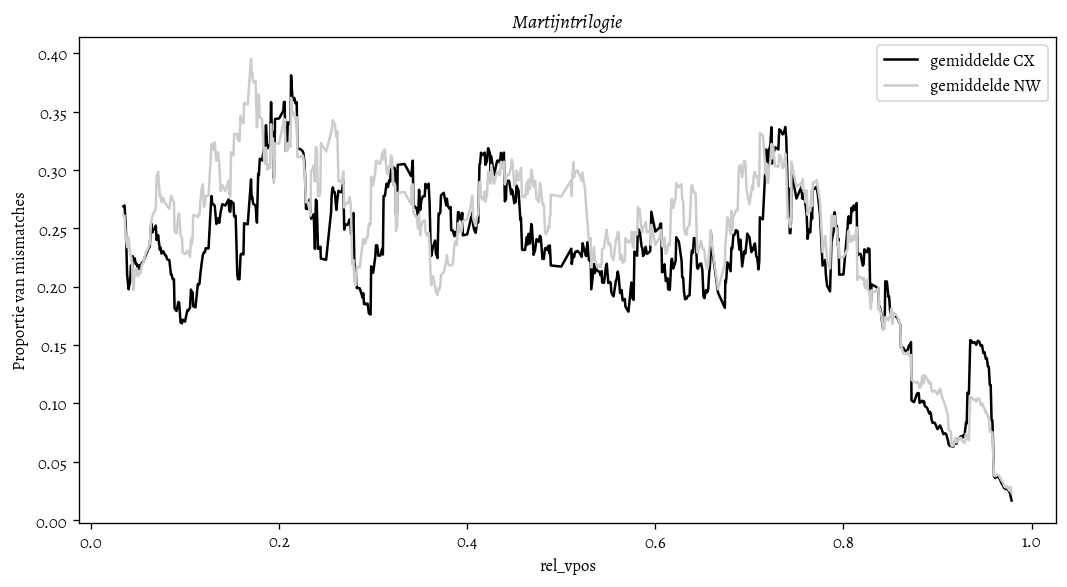

In [10]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
rolling_window = df.groupby('rel_vpos')['mismatch'].mean().rolling(window=20).mean()
rolling_window2 = df2.groupby('rel_vpos')['mismatch'].mean().rolling(window=20).mean()
rolling_window.plot(ax=ax, label="gemiddelde CX", color='black')
rolling_window2.plot(ax=ax, label="gemiddelde NW", color='#cccccc')
ax.set_title('$\mathit{Martijntrilogie}$')
ax.set_ylabel('Proportie van mismatches')
plt.legend()
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/rolling_window_mismatch_proportion.png')

### Verdelen in kwantielen - bayesiaans regressiemodel

In [12]:
df['q_pos'], bins = pd.qcut(df['rel_vpos'], q=6, retbins=True)
df['q_pos'].value_counts()
#df2['q_pos'], bins = pd.qcut(df['rel_vpos'], q=6, retbins=True)
#df2['q_pos'].value_counts()

q_pos
(-0.001, 0.148]    273550
(0.649, 0.815]     272807
(0.316, 0.481]     271580
(0.481, 0.649]     270563
(0.148, 0.316]     270032
(0.815, 0.979]     269709
Name: count, dtype: int64

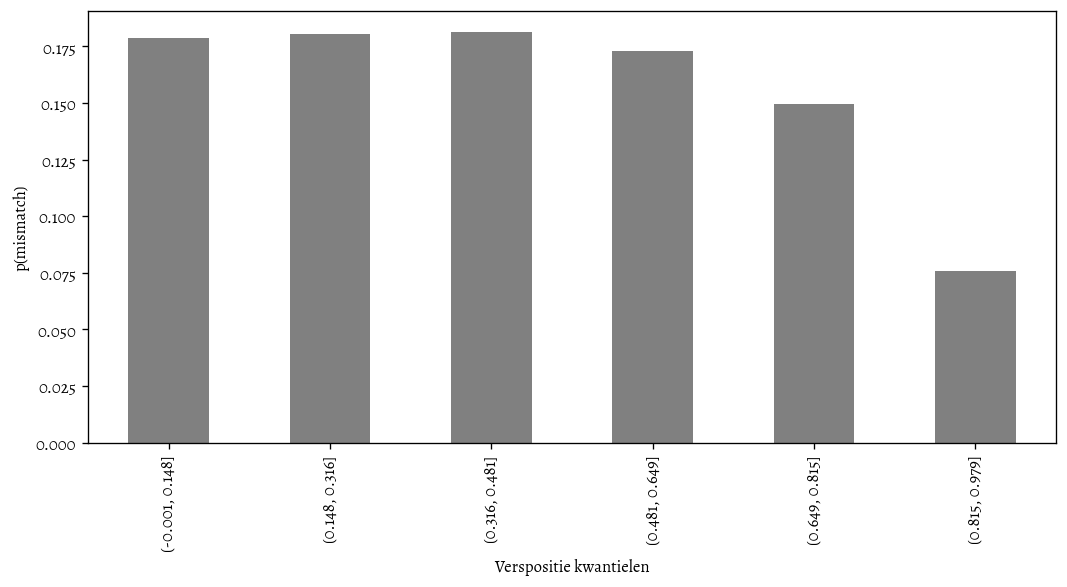

In [13]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
df.groupby('q_pos', observed=False)['mismatch'].mean().plot.bar(color='gray')
#ax.set_xlabel('Verse position quantiles');
ax.set_xlabel('Verspositie kwantielen');
ax.set_ylabel('p(mismatch)');
plt.tight_layout();
plt.savefig('../data/figures_martijntrilogie/p(mismatch)quantile.png')

Modeling the probability that mismatch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, q_pos]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.
/Users/sofiemoors/miniconda3/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: q_pos


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.499,0.063,-1.618,-1.382,0.001,0.001,3418.0,4312.0,1.0
"q_pos[(0.148, 0.316]]",0.011,0.088,-0.147,0.185,0.001,0.001,4468.0,5829.0,1.0
"q_pos[(0.316, 0.481]]",-0.039,0.092,-0.210,0.129,0.001,0.001,4245.0,5246.0,1.0
"q_pos[(0.481, 0.649]]",-0.129,0.090,-0.292,0.044,0.001,0.001,4566.0,5651.0,1.0
"q_pos[(0.649, 0.815]]",-0.267,0.093,-0.438,-0.087,0.001,0.001,4821.0,6349.0,1.0
"q_pos[(0.815, 0.979]]",-1.212,0.118,-1.445,-1.000,0.002,0.001,5243.0,6084.0,1.0


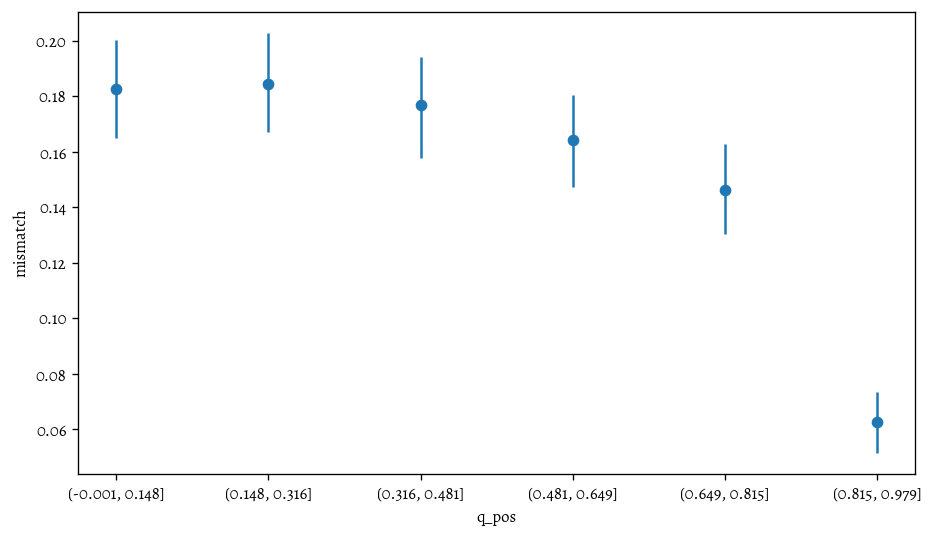

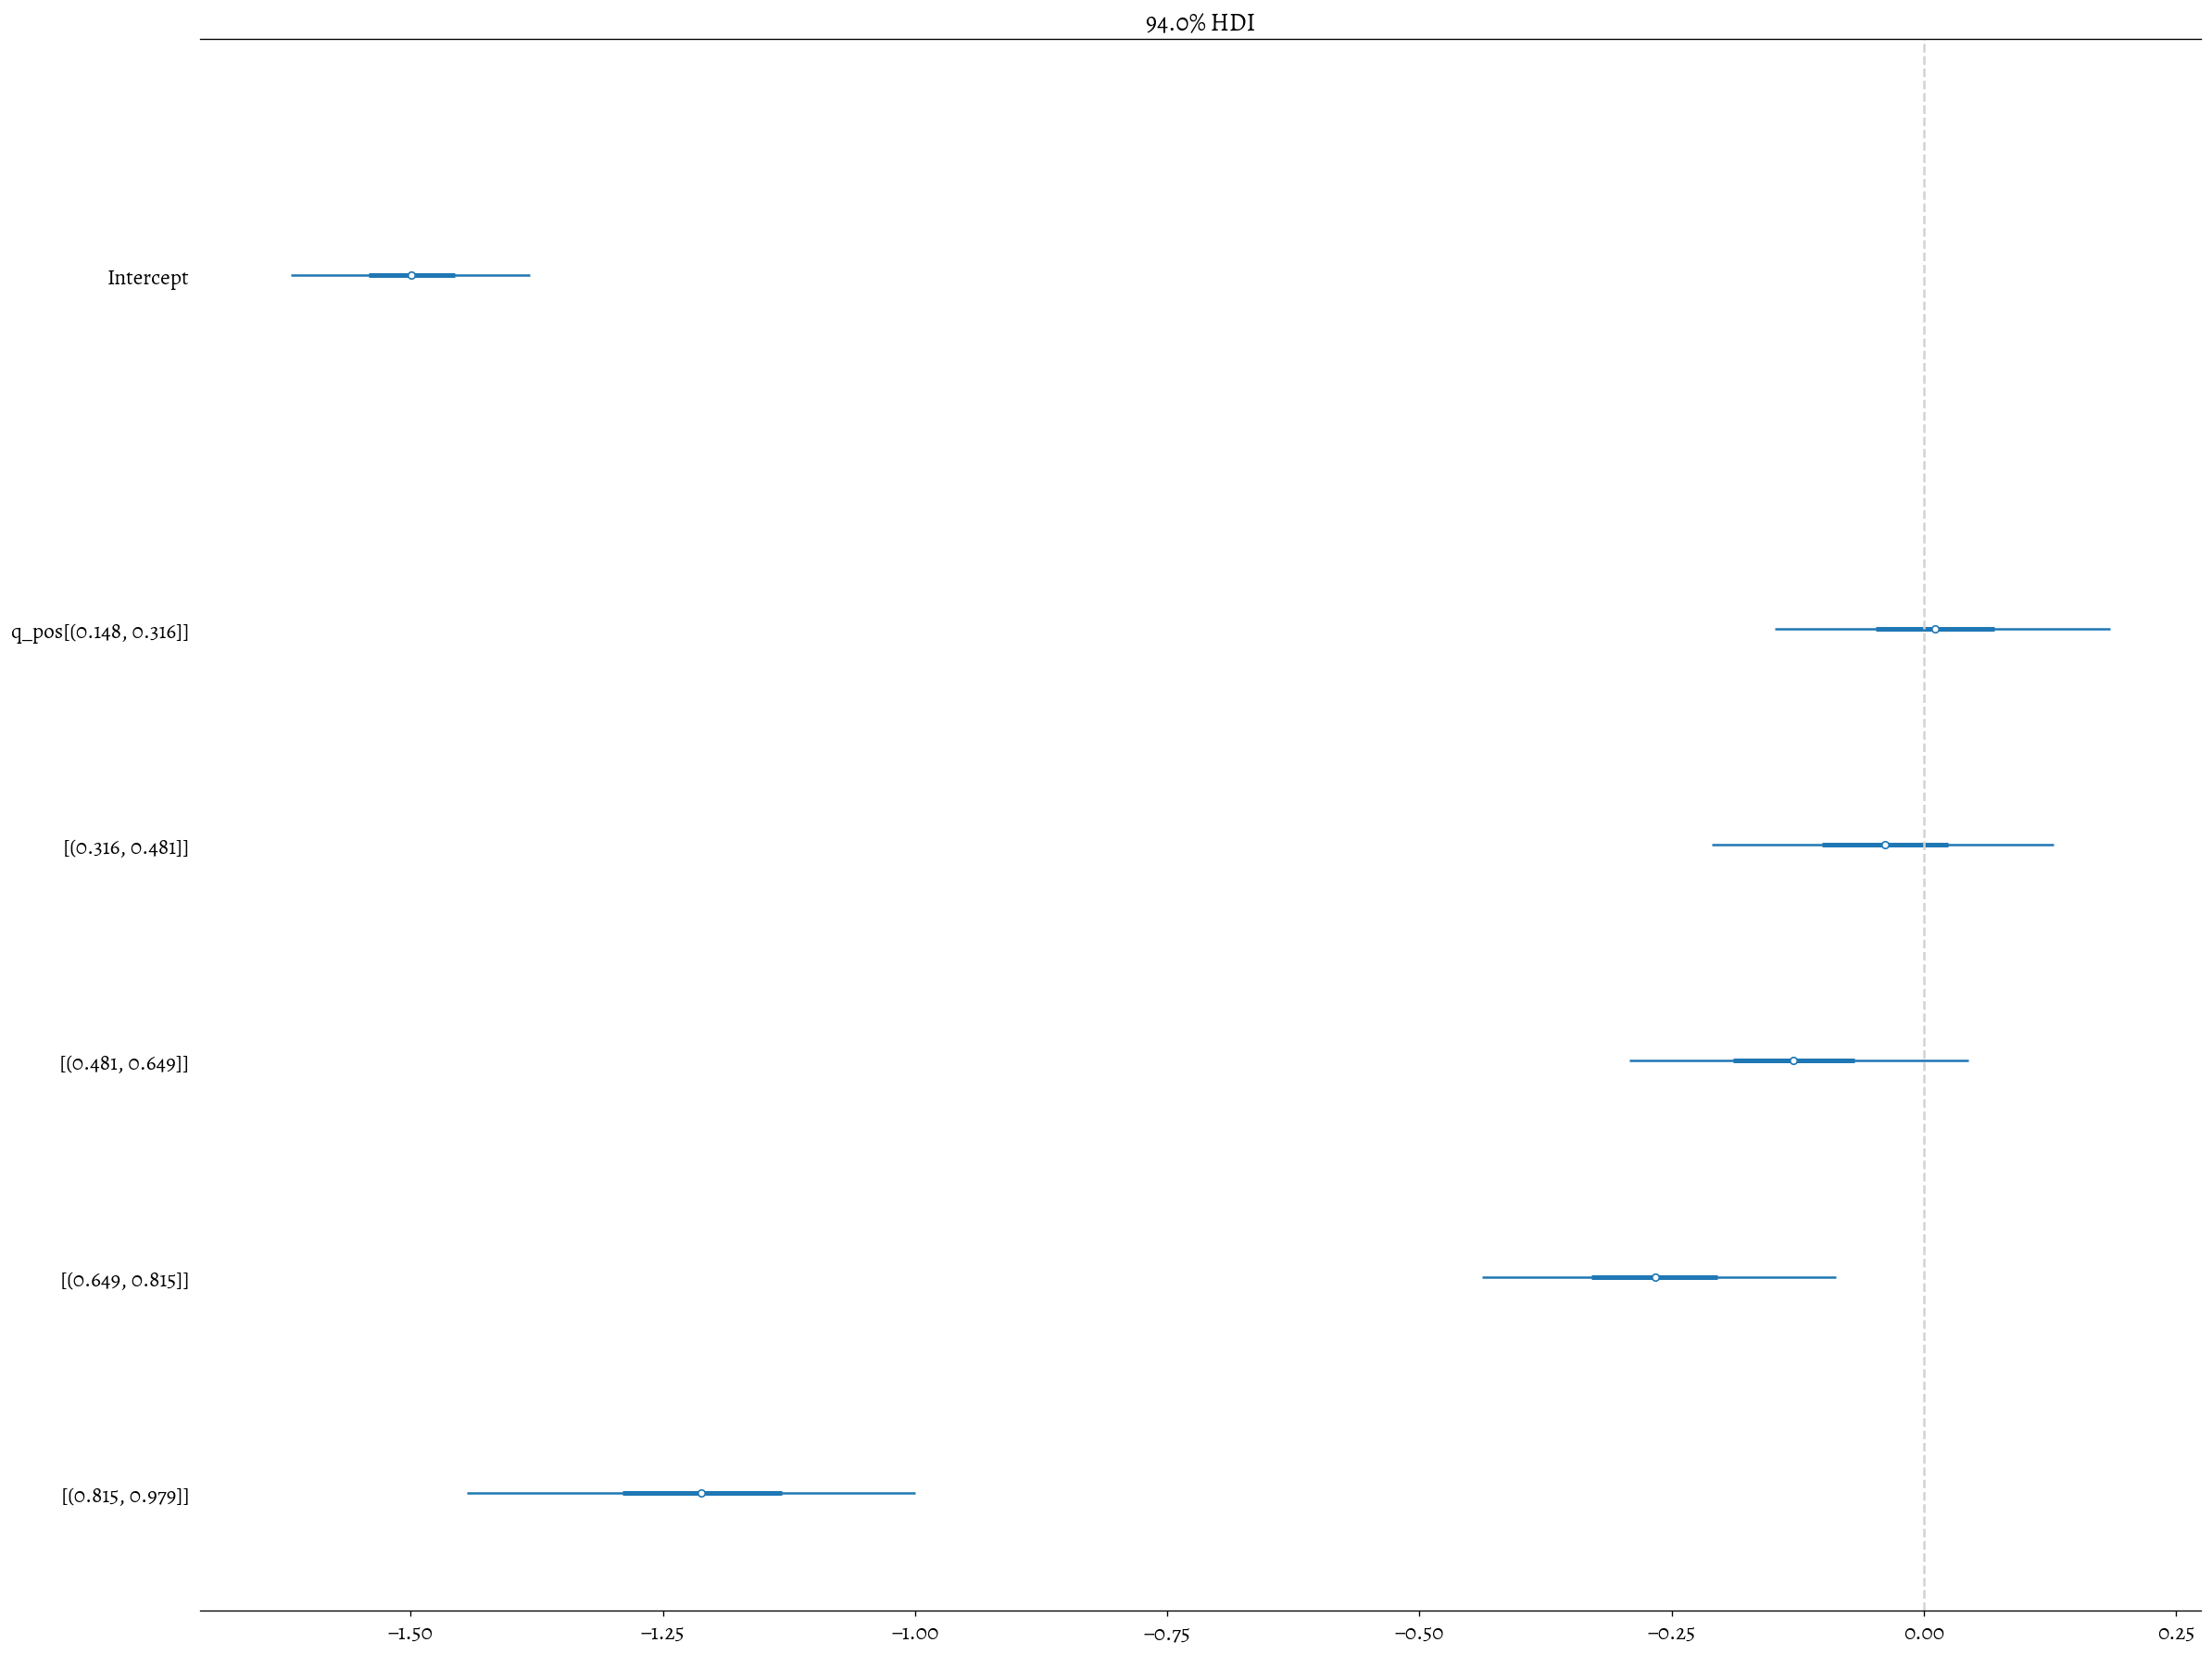

In [16]:
import pytensor
pytensor.config.cxx = ""
df = df.sample(10000)
pos_model = bmb.Model('mismatch ~ q_pos', df, family='bernoulli')
#pos_fit = pos_model.fit(draws=1000, chains=4, idata_kwargs={'log_likelihood':True})
pos_fit = pos_model.fit(draws=2000, chains=4)
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
bmb.interpret.plot_predictions(pos_model, pos_fit, ["q_pos"], ax=ax);
plt.savefig('../data/figures_martijntrilogie/bmbmodel.png')
fig, ax = plt.subplots(figsize=(20, 15), dpi=120)
az.plot_forest(pos_fit, combined=True, figsize=(12, 6), ax=ax)
plt.axvline(0, c='lightgrey', ls='--');
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/forestplot.png')

az.summary(pos_fit)

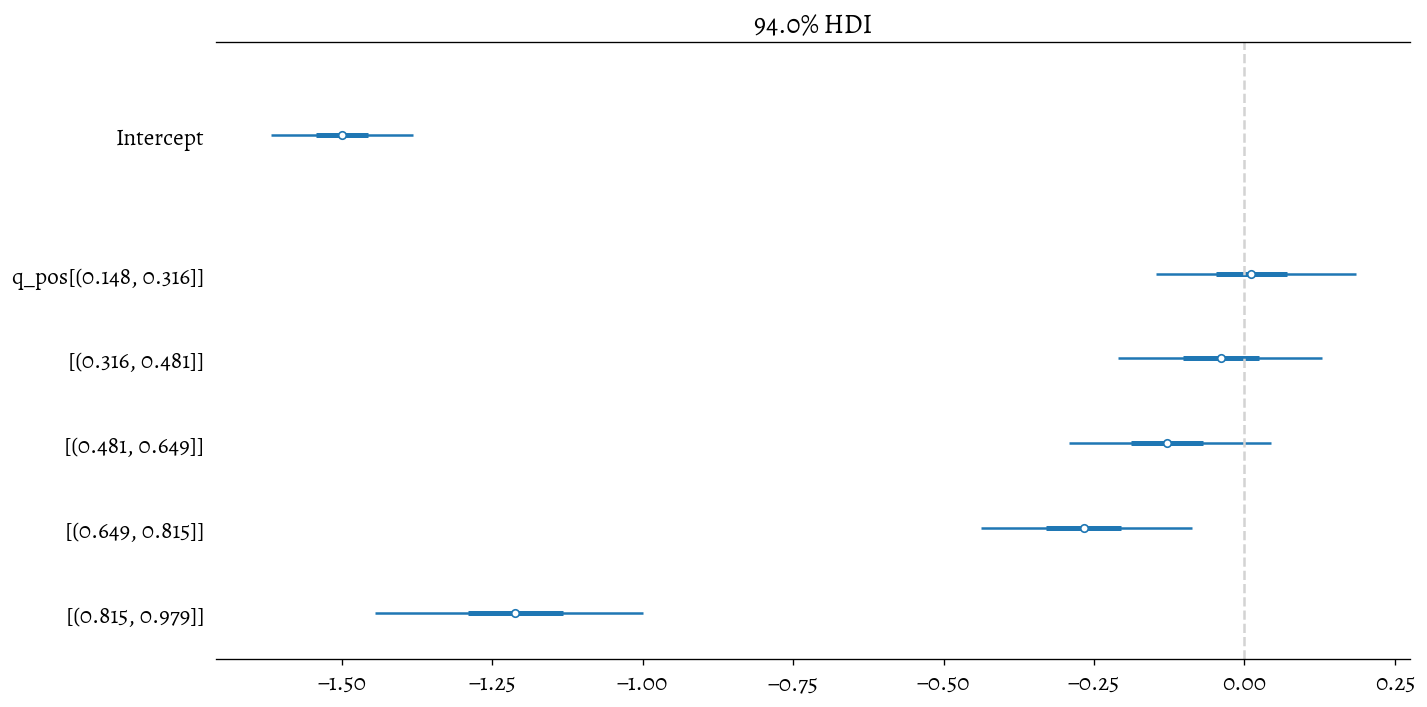

In [17]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
az.plot_forest(pos_fit, combined=True, figsize=(12, 6), ax=ax)
plt.axvline(0, c='lightgrey', ls='--');
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/forestplot.png')

### Directionele test

['(0.148, 0.316]' '(0.316, 0.481]' '(0.481, 0.649]' '(0.649, 0.815]'
 '(0.815, 0.979]']
P(rijmpositie heeft lagere mismatch dan begin) = 1.0000


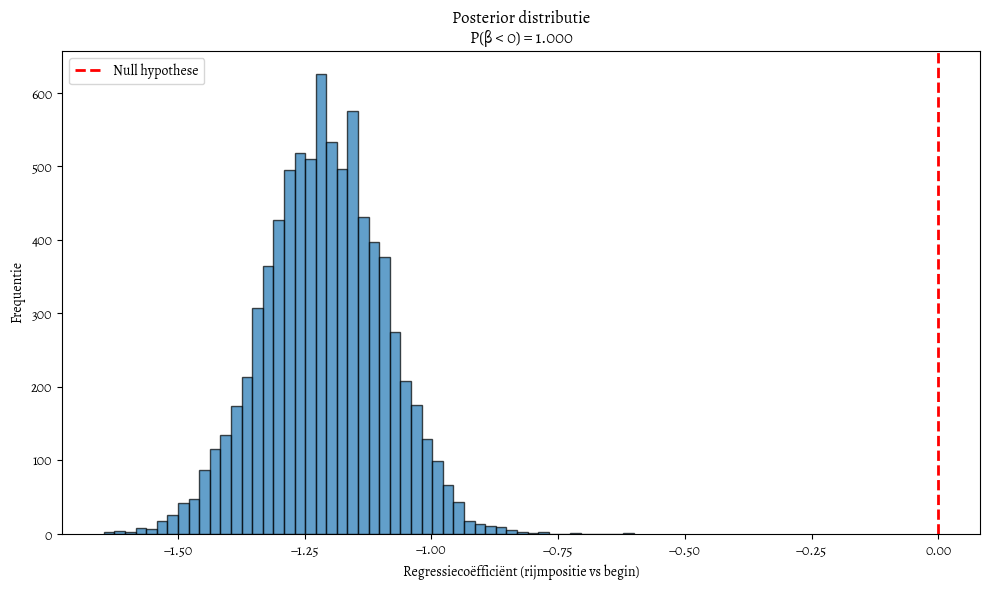

In [19]:
posterior_samples = pos_fit.posterior['q_pos'].values
posterior_flat = posterior_samples.reshape(-1, posterior_samples.shape[-1])
print(pos_fit.posterior['q_pos_dim'].values)
rhyme_coef = posterior_flat[:, -1]  
# Directionele test: P(β < 0)
p_rhyme_lower = (rhyme_coef < 0).mean()
print(f"P(rijmpositie heeft lagere mismatch dan begin) = {p_rhyme_lower:.4f}")

# Visualisatie
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rhyme_coef, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Null hypothese')
ax.set_xlabel('Regressiecoëfficiënt (rijmpositie vs begin)')
ax.set_ylabel('Frequentie')
ax.set_title(f'Posterior distributie\nP(β < 0) = {p_rhyme_lower:.3f}')
ax.legend()
plt.tight_layout()

## Lexicale variatie: vergelijking op lemmaniveau

In [60]:
df = pd.read_csv('../data/matches_martijntrilogie/matches_lemma_cx.csv', header=0)
df2 = pd.read_csv('../data/matches_martijntrilogie/matches_lemma_nw.csv', header=0)
df = df.rename(columns={'relative position': 'rel_vpos'})
df2 = df2.rename(columns={'relative position': 'rel_vpos'})

# Filter df
df = df[df['id_ms'] != 'M3_39_508']
df = df[df['id_ms'] != 'M1_75_976']
df = df[df['id_ms'] != 'M1_01_000']
df = df[df['id_ms'] != 'M2_01_000']
df = df[df['id_ms'] != 'M3_01_000']
df = df[df['id_ms'] != 'M2_26_339']
df = df[df['line1'] != 'dominus']
df = df[df['line2'] != 'dominus']

# Filter df2 
df2 = df2[df2['id_ms'] != 'M3_39_508']
df2 = df2[df2['id_ms'] != 'M1_75_976']
df2 = df2[df2['id_ms'] != 'M1_01_000']
df2 = df2[df2['id_ms'] != 'M2_01_000']
df2 = df2[df2['id_ms'] != 'M3_01_000']
df2 = df2[df2['id_ms'] != 'M2_26_339']
df2 = df2[df2['line1'] != 'dominus']
df2 = df2[df2['line2'] != 'dominus']

print(f"df shape: {df.shape}")
print(f"df2 shape: {df2.shape}")
print(f"df mismatch mean: {df['mismatch'].mean():.4f}")
print(f"df2 mismatch mean: {df2['mismatch'].mean():.4f}")

print(df)
print(df2)

df shape: (326532, 16)
df2 shape: (326446, 16)
df mismatch mean: 0.2432
df2 mismatch mean: 0.2430
       ms1 ms2            text      id_ms text_part  stanza  verse  \
0        A   B  Martijntrilogy  M3_18_224        M3      18    224   
1        A   B  Martijntrilogy  M3_18_224        M3      18    224   
2        A   B  Martijntrilogy  M3_18_224        M3      18    224   
3        A   B  Martijntrilogy  M3_18_224        M3      18    224   
4        A   B  Martijntrilogy  M1_65_844        M1      65    844   
...     ..  ..             ...        ...       ...     ...    ...   
326527   W   Z  Martijntrilogy  M3_08_092        M3       8     92   
326528   W   Z  Martijntrilogy  M3_08_092        M3       8     92   
326529   W   Z  Martijntrilogy  M3_08_092        M3       8     92   
326530   W   Z  Martijntrilogy  M3_08_092        M3       8     92   
326531   W   Z  Martijntrilogy  M3_08_092        M3       8     92   

        position_verse  rel_vpos  mismatch  lemma1  lemma2  \

In [61]:
unieke_combinaties = df2.groupby(['id_ms', 'ms1', 'ms2']).ngroups
print(unieke_combinaties)
print(f"Gemiddelde kans op mismatch (lemma-niveau): {df['mismatch'].mean():.3f} ({df['mismatch'].mean()*100:.1f}%)")

58951
Gemiddelde kans op mismatch (lemma-niveau): 0.243 (24.3%)


Unieke vers-manuscriptpaar combinaties: 58951
Aantal 'is_last_word' = True: 58951
Kloppen de aantallen? True
Unieke vers-manuscriptpaar combinaties: 58951
Aantal 'is_last_word' = True: 58951
Kloppen de aantallen? True

=== VERDELING ===
is_last_word
False    267581
True      58951
Name: count, dtype: int64

=== VERDELING_nw ===
is_last_word
False    267495
True      58951
Name: count, dtype: int64

=== MISMATCH RATE ===
Overige woorden         0.247974
Laatste woord (rijm)    0.221574
Name: mismatch, dtype: float64

=== MISMATCH RATE_nw===
Overige woorden         0.247672
Laatste woord (rijm)    0.221574
Name: mismatch, dtype: float64


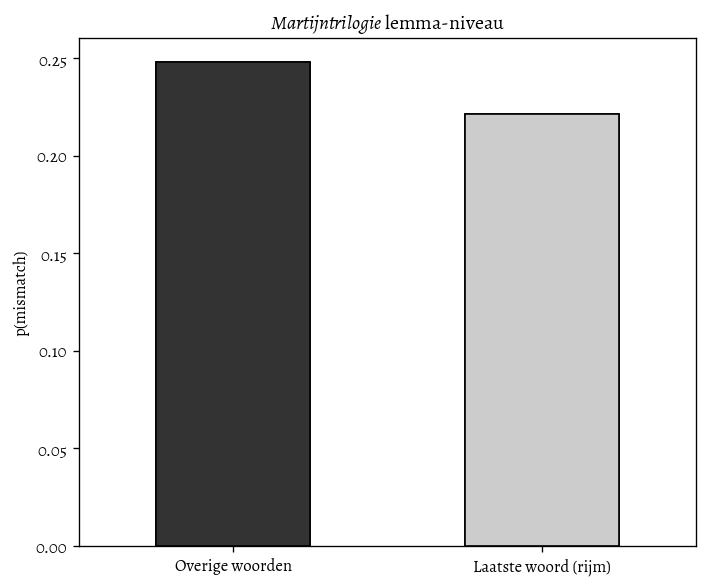


Overige woorden: 24.8%
Laatste woord (rijm): 22.2%
Mann-Whitney U test: p = 1.12e-41
Verschil: 0.026 (10.6% minder)

Overige woorden: 24.8%
Laatste woord (rijm): 22.2%
Mann-Whitney U test: p = 1.12e-41
Verschil: 0.026 (10.5% minder)


In [66]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'

max_pos_per_pair = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')
max_pos_per_pair2 = df2.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')

df['is_last_word'] = df['rel_vpos'] == max_pos_per_pair
df2['is_last_word'] = df2['rel_vpos'] == max_pos_per_pair2

unieke_combinaties = df.groupby(['id_ms', 'ms1', 'ms2']).ngroups
print(f"Unieke vers-manuscriptpaar combinaties: {unieke_combinaties}")
print(f"Aantal 'is_last_word' = True: {df['is_last_word'].sum()}")
print(f"Kloppen de aantallen? {unieke_combinaties == df['is_last_word'].sum()}")

unieke_combinaties_nw = df2.groupby(['id_ms', 'ms1', 'ms2']).ngroups
print(f"Unieke vers-manuscriptpaar combinaties: {unieke_combinaties}")
print(f"Aantal 'is_last_word' = True: {df2['is_last_word'].sum()}")
print(f"Kloppen de aantallen? {unieke_combinaties == df2['is_last_word'].sum()}")

print("\n=== VERDELING ===")
print(df['is_last_word'].value_counts())

print("\n=== VERDELING_nw ===")
print(df2['is_last_word'].value_counts())


print("\n=== MISMATCH RATE ===")
comparison = df.groupby('is_last_word')['mismatch'].mean()
comparison.index = ['Overige woorden', 'Laatste woord (rijm)']
print(comparison)

print("\n=== MISMATCH RATE_nw===")
comparison2 = df2.groupby('is_last_word')['mismatch'].mean()
comparison2.index = ['Overige woorden', 'Laatste woord (rijm)']
print(comparison2)

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
comparison.plot.bar(ax=ax, color=['#7fbfbf', '#feffb3'], edgecolor='black')
comparison.plot.bar(ax=ax, color=['#333333', '#cccccc'], edgecolor='black')
ax.set_ylabel('p(mismatch)')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.set_title('$\mathit{Martijntrilogie}$ lemma-niveau')
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/rijmwoord_vs_rest.png', dpi=300)
plt.show()

from scipy import stats

last_word = df[df['is_last_word'] == True]['mismatch']
other_words = df[df['is_last_word'] == False]['mismatch']

last_wordnw = df2[df2['is_last_word'] == True]['mismatch']
other_wordsnw = df2[df2['is_last_word'] == False]['mismatch']


stat, p_value = stats.mannwhitneyu(last_word, other_words)
stat2, p_value2 = stats.mannwhitneyu(last_wordnw, other_wordsnw)

print(f"\nOverige woorden: {other_words.mean()*100:.1f}%")
print(f"Laatste woord (rijm): {last_word.mean()*100:.1f}%")
print(f"Mann-Whitney U test: p = {p_value:.2e}")
print(f"Verschil: {(other_words.mean() - last_word.mean()):.3f} ({((other_words.mean() - last_word.mean()) / other_words.mean() * 100):.1f}% minder)")

print(f"\nOverige woorden: {other_wordsnw.mean()*100:.1f}%")
print(f"Laatste woord (rijm): {last_wordnw.mean()*100:.1f}%")
print(f"Mann-Whitney U test: p = {p_value:.2e}")
print(f"Verschil: {(other_wordsnw.mean() - last_wordnw.mean()):.3f} ({((other_wordsnw.mean() - last_wordnw.mean()) / other_wordsnw.mean() * 100):.1f}% minder)")

Modeling the probability that mismatch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, is_last_word]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 151 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -1.128  0.010  -1.148   -1.109        0.0      0.0    4133.0   
is_last_word -0.187  0.032  -0.245   -0.125        0.0      0.0    4192.0   

              ess_tail  r_hat  
Intercept       3195.0    1.0  
is_last_word    2889.0    1.0  


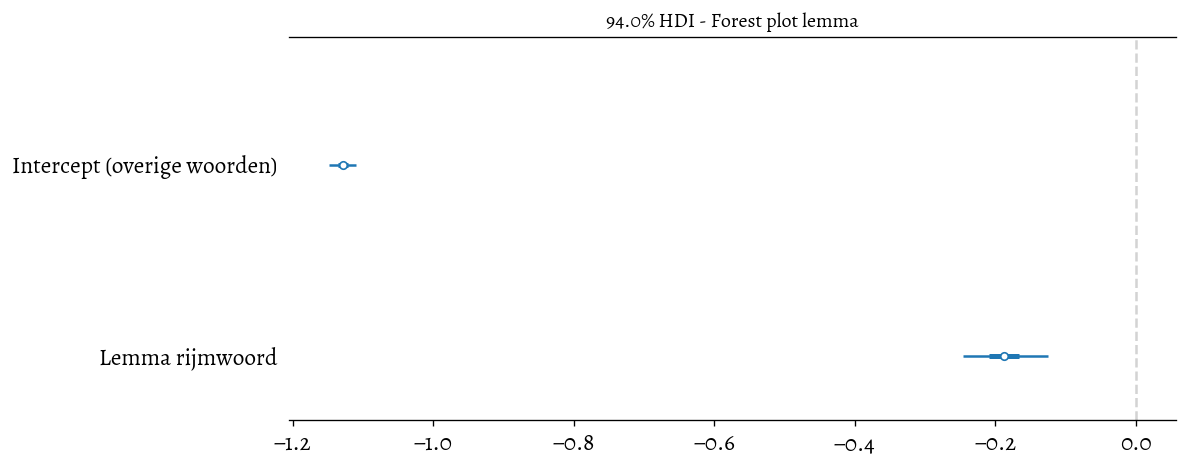


=== GESCHATTE MISMATCH-KANSEN ===
Overige woorden:        24.4% (HDI: [24.1%, 24.8%])
Laatste woord (rijm):   21.2% (HDI: [20.2%, 22.1%])


In [48]:
import pytensor
pytensor.config.cxx = ""
import pytensor
pytensor.config.cxx = '/usr/bin/clang++' 

# Bayesiaans model
pos_model = bmb.Model('mismatch ~ is_last_word', df_sample, family='bernoulli')
pos_fit = pos_model.fit(draws=1000, chains=4, cores=1)

# Summary
print(az.summary(pos_fit))

# Forest plot - EERST fig/ax maken, DAN plotten
fig, ax = plt.subplots(figsize=(10, 4), dpi=120)
az.plot_forest(
    pos_fit, 
    combined=True, 
    ax=ax,
    var_names=['Intercept', 'is_last_word']
)

# Labels handmatig aanpassen
labels = [item.get_text() for item in ax.get_yticklabels()]
new_labels = []
for label in labels:
    if 'Intercept' in label:
        new_labels.append('Intercept (overige woorden)')
    elif 'is_last_word' in label:
        new_labels.append('Lemma rijmwoord')
    else:
        new_labels.append(label)
ax.set_yticklabels(new_labels)

plt.axvline(0, c='lightgrey', ls='--')
ax.set_title('94.0% HDI - Forest plot lemma')
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/lemma_forestplot.png', dpi=300)
plt.show()

# Kansberekeningen
import numpy as np
intercept = pos_fit.posterior['Intercept'].values.flatten()
rijm_coef = pos_fit.posterior['is_last_word'].values.flatten()

prob_overig = 1 / (1 + np.exp(-intercept))
prob_rijm = 1 / (1 + np.exp(-(intercept + rijm_coef)))

print("\n=== GESCHATTE MISMATCH-KANSEN ===")
print(f"Overige woorden:        {prob_overig.mean()*100:.1f}% (HDI: [{np.percentile(prob_overig, 3)*100:.1f}%, {np.percentile(prob_overig, 97)*100:.1f}%])")
print(f"Laatste woord (rijm):   {prob_rijm.mean()*100:.1f}% (HDI: [{np.percentile(prob_rijm, 3)*100:.1f}%, {np.percentile(prob_rijm, 97)*100:.1f}%])")

### Inclusief eerste woord van het vers

In [51]:
# Bepaal de max positie per vers (= laatste woord)
max_pos_per_verse = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')

# Categoriseer
df['word_position'] = 'midden'
df.loc[df['rel_vpos'] == 0.0, 'word_position'] = 'eerste woord'
df.loc[df['rel_vpos'] == max_pos_per_verse, 'word_position'] = 'laatste woord (rijm)'

# Maak er een categorische variabele van met de juiste volgorde
df['word_position'] = pd.Categorical(df['word_position'], 
                                      categories=['eerste woord', 'midden', 'laatste woord (rijm)'], 
                                      ordered=True)

# Bekijk de verdeling
print("Verdeling:")
print(df['word_position'].value_counts())
print("\nMismatch rate per positie:")
print(df.groupby('word_position')['mismatch'].mean())

Verdeling:
word_position
midden                  208630
eerste woord             58951
laatste woord (rijm)     58951
Name: count, dtype: int64

Mismatch rate per positie:
word_position
eerste woord            0.210225
midden                  0.258640
laatste woord (rijm)    0.221574
Name: mismatch, dtype: float64


/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_26136/2625731034.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('word_position')['mismatch'].mean())


In [53]:
# Bayesiaans model
pytensor.config.cxx = '/usr/bin/clang++' 
df_sample = df.sample(10000, random_state=42)

pos_model = bmb.Model('mismatch ~ word_position', df_sample, family='bernoulli')
pos_fit = pos_model.fit(draws=1000, chains=4)

# Summary
print(az.summary(pos_fit))

Modeling the probability that mismatch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, word_position]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


                                      mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                           -1.385  0.059  -1.488   -1.266      0.001   
word_position[midden]                0.353  0.065   0.231    0.476      0.001   
word_position[laatste woord (rijm)]  0.160  0.079   0.013    0.309      0.002   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                              0.001    2359.0    2407.0    1.0  
word_position[midden]                  0.001    2557.0    2362.0    1.0  
word_position[laatste woord (rijm)]    0.001    2416.0    2578.0    1.0  


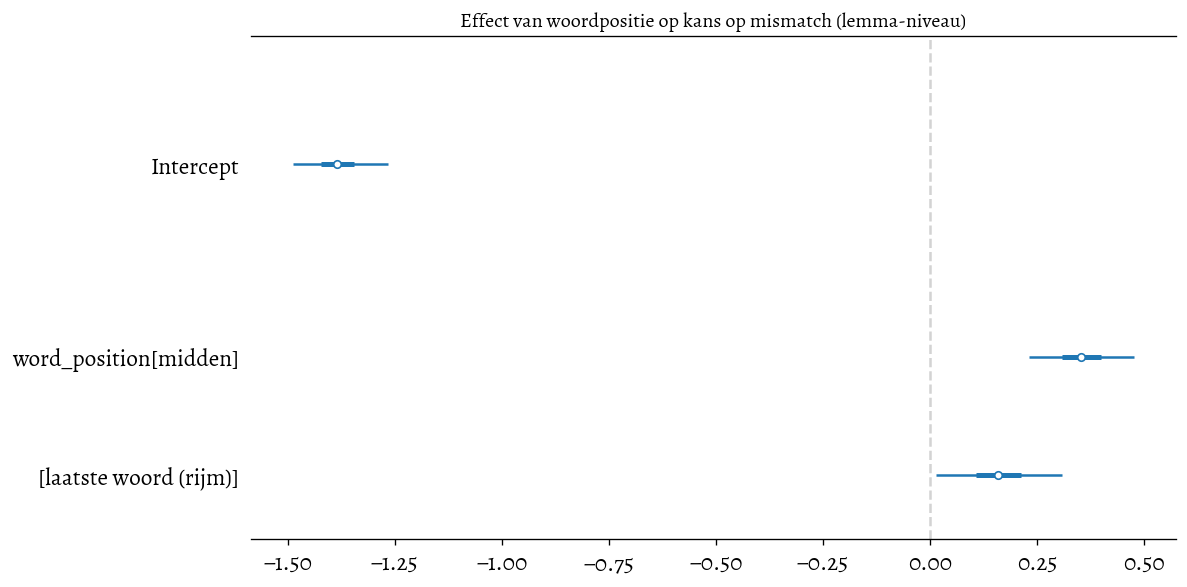

In [54]:
# Forest plot
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
az.plot_forest(pos_fit, combined=True, ax=ax)
plt.axvline(0, c='lightgrey', ls='--')
ax.set_title('Effect van woordpositie op kans op mismatch (lemma-niveau)')
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/lemma_forestplot_inclusiefeerstewoord.png', dpi=300)
plt.show()

=== VERDELING ===
word_position
midden                  208544
eerste woord             58951
laatste woord (rijm)     58951
Name: count, dtype: int64

=== MISMATCH RATE ===
word_position
eerste woord            0.209835
midden                  0.258368
laatste woord (rijm)    0.221574
Name: mismatch, dtype: float64


/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_26136/2810199293.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparison = df2.groupby('word_position')['mismatch'].mean()


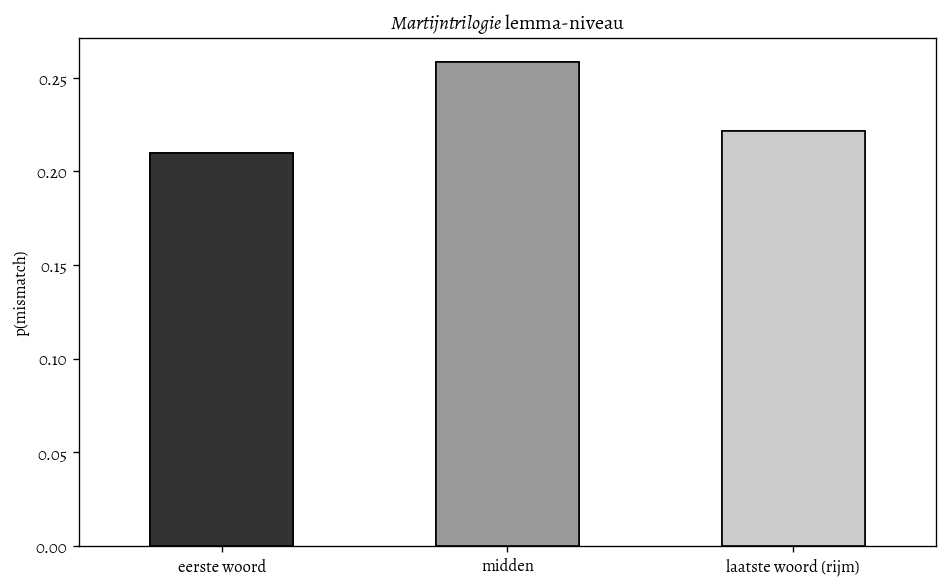


=== STATISTISCHE TESTS ===
Eerste woord:        21.0%
Midden:              25.8%
Laatste woord (rijm): 22.2%

Eerste vs Midden: p = 2.32e-128
  Verschil: 4.9 procentpunt

Midden vs Laatste: p = 4.30e-74
  Verschil: 3.7 procentpunt

Eerste vs Laatste: p = 9.60e-07
  Verschil: -1.2 procentpunt

=== EFFECTGROOTTES (Cohen's h) ===
Eerste vs Midden:  -0.115
Midden vs Laatste: 0.086
Eerste vs Laatste: -0.029


In [56]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'

# Bepaal eerste en laatste woord per vers-manuscriptpaar
max_pos_per_pair = df2.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')
min_pos_per_pair = df2.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('min')

df2['is_last_word'] = df2['rel_vpos'] == max_pos_per_pair
df2['is_first_word'] = df2['rel_vpos'] == min_pos_per_pair

# Maak een categorische variabele
df2['word_position'] = 'midden'
df2.loc[df2['is_first_word'], 'word_position'] = 'eerste woord'
df2.loc[df2['is_last_word'], 'word_position'] = 'laatste woord (rijm)'

# Zet in juiste volgorde
df2['word_position'] = pd.Categorical(
    df2['word_position'], 
    categories=['eerste woord', 'midden', 'laatste woord (rijm)'], 
    ordered=True
)

# Bekijk de verdeling
print("=== VERDELING ===")
print(df2['word_position'].value_counts())

# Mismatch rate per positie
print("\n=== MISMATCH RATE ===")
comparison = df2.groupby('word_position')['mismatch'].mean()
print(comparison)

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
comparison.plot.bar(ax=ax, color=['#7fbfbf', '#a8d5ba', '#feffb3'], edgecolor='black')
comparison.plot.bar(ax=ax, color=['#333333', '#999999', '#cccccc'], edgecolor='black')
ax.set_ylabel('p(mismatch)')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.set_title('$\mathit{Martijntrilogie}$ lemma-niveau')
plt.tight_layout()
plt.savefig('../data/figures_martijntrilogie/woordpositie_drie_categorieen.png', dpi=300)
plt.show()

# Statistische tests
from scipy import stats

eerste = df2[df2['word_position'] == 'eerste woord']['mismatch']
midden = df2[df2['word_position'] == 'midden']['mismatch']
laatste = df2[df2['word_position'] == 'laatste woord (rijm)']['mismatch']

print("\n=== STATISTISCHE TESTS ===")
print(f"Eerste woord:        {eerste.mean()*100:.1f}%")
print(f"Midden:              {midden.mean()*100:.1f}%")
print(f"Laatste woord (rijm): {laatste.mean()*100:.1f}%")

# Test eerste vs midden
stat, p_value = stats.mannwhitneyu(eerste, midden)
print(f"\nEerste vs Midden: p = {p_value:.2e}")
print(f"  Verschil: {(midden.mean() - eerste.mean())*100:.1f} procentpunt")

# Test midden vs laatste
stat, p_value = stats.mannwhitneyu(midden, laatste)
print(f"\nMidden vs Laatste: p = {p_value:.2e}")
print(f"  Verschil: {(midden.mean() - laatste.mean())*100:.1f} procentpunt")

# Test eerste vs laatste
stat, p_value = stats.mannwhitneyu(eerste, laatste)
print(f"\nEerste vs Laatste: p = {p_value:.2e}")
print(f"  Verschil: {(eerste.mean() - laatste.mean())*100:.1f} procentpunt")

# Effectgroottes (Cohen's h)
import numpy as np

def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

print("\n=== EFFECTGROOTTES (Cohen's h) ===")
print(f"Eerste vs Midden:  {cohens_h(eerste.mean(), midden.mean()):.3f}")
print(f"Midden vs Laatste: {cohens_h(midden.mean(), laatste.mean()):.3f}")
print(f"Eerste vs Laatste: {cohens_h(eerste.mean(), laatste.mean()):.3f}")